## FAKE NEWS DETECTION MODEL

Instructions: You only have to run the Imports, Loading, and User Input sections. When asked for user input, put 1 if you have a text to analyze or put 2 if you have an URL to extract text from. Our model will then tell you whether it is fake or not.

Note for URLs: Some websites do not give permission to extract text to prevent being used as AI training material.

# Imports + Mounting

In [ ]:
# Basic imports
import math
import io
import os

import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

# counter: for counting words to make plot
from collections import Counter

# nltk: for removing stopwords and lemmatization
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.feature_extraction.text import TfidfVectorizer # for vectorizer
from sklearn.manifold import TSNE # for visualizing the vectorized data
from sklearn.linear_model import LogisticRegression # for logistic regression
from sklearn.svm import SVC # for SVM
from sklearn.tree import DecisionTreeClassifier # for decision tree
from sklearn.ensemble import BaggingClassifier # for bagging and adaboost
from sklearn.metrics import accuracy_score # for calculating accuracy scores
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix # for evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score # more evaluation metrics

# keras: for artificial neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

# pickle: for saving models and sets
import pickle

# lxml[html_clean] and newspaper3k: for extracting words from article URLs
!pip install lxml[html_clean]
!pip install newspaper3k
from newspaper import Article

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
pathname = "/content/drive/My Drive/Data Mining Project"
os.chdir(pathname)

# Analysis

## 1. Getting The Dataset

In [ ]:
fake_news = pd.read_csv('/content/drive/My Drive/Data Mining Project/Datasets/Fake.csv')
true_news = pd.read_csv('/content/drive/My Drive/Data Mining Project/Datasets/True.csv')

In [ ]:
fake_news['combined'] = fake_news['title'] + " " + fake_news['text']
true_news['combined'] = true_news['title'] + " " + true_news['text']
fake_news['label'] = 1
true_news['label'] = 0

In [ ]:
fake_news.head()

,title,text,subject,date,combined,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...,1


In [ ]:
true_news.head()

,title,text,subject,date,combined,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,0


### Seeing the time span of the dataset

In [ ]:
# Convert 'date' columns to datetime objects, specifying the correct format
fake_news['date'] = pd.to_datetime(fake_news['date'], format='%B %d, %Y', errors='coerce')
true_news['date'] = pd.to_datetime(true_news['date'], format='%B %d, %Y', errors='coerce')


# Get the earliest and latest dates from both DataFrames
earliest_date = min(fake_news['date'].min(), true_news['date'].min())
latest_date = max(fake_news['date'].max(), true_news['date'].max())

# Print the results
print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 2015-05-01 00:00:00
Latest Date: 2017-12-31 00:00:00


## 2. Data Prepocessing

### 2.1. Checking for missing values

In [ ]:
print(fake_news.isnull().sum())
print(true_news.isnull().sum())

title           0
text            0
subject         0
date        11613
combined        0
label           0
dtype: int64
title           0
text            0
subject         0
date        21417
combined        0
label           0
dtype: int64


### 2.2. Checking for duplicate values

In [ ]:
fake_news.shape

(23481, 6)

In [ ]:
true_news.shape

(21417, 6)

In [ ]:
# Dropping duplicates from the 2 datasets.
fake_news = fake_news.drop_duplicates(subset=['text'], keep='first')
true_news = true_news.drop_duplicates(subset=['text'], keep='first')

In [ ]:
fake_news.shape

(17455, 6)

In [ ]:
true_news.shape

(21192, 6)

### 2.3. Cleaning text and title columns (remove URLS, mentions,....)


In [ ]:
# The first row of text BEFORE cleaning
print(fake_news['combined'][0])

 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this d

In [ ]:
# Create Function To Clean The Text.
import re
def clean_text(text):
    text = re.sub(r"http\S+", " ", text)  # Remove URLs
    text = re.sub(r"@\w+", " ", text)     # Remove mentions
    text = re.sub(r"#\w+", " ", text)     # Remove hashtags
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = text.lower().strip()           # Convert to lowercase and strip whitespace
    return text

In [ ]:
# Now, let's clean the fake and true news.
fake_news['combined'] = fake_news['combined'].apply(clean_text)
true_news['combined'] = true_news['combined'].apply(clean_text)

In [ ]:
# The first row of text AFTER cleaning
print(fake_news['combined'][0])

donald trump sends out embarrassing new year s eve message  this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that  instead  he had to give a shout out to his enemies  haters and  the very dishonest fake news media   the former reality show star had just one job to do and he couldn t do it  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year   president angry pants tweeted   2018 will be a great year for america  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year  2018 will be a great year for america   donald j  trump     december 31  2017trump s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable  petty

### 2.4. Removing stop words

In [ ]:
# The first row of text BEFORE cleaning
print(fake_news['combined'][0])

donald trump sends out embarrassing new year s eve message  this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that  instead  he had to give a shout out to his enemies  haters and  the very dishonest fake news media   the former reality show star had just one job to do and he couldn t do it  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year   president angry pants tweeted   2018 will be a great year for america  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year  2018 will be a great year for america   donald j  trump     december 31  2017trump s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable  petty

In [ ]:
# Set of stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return ' '.join(filtered_sentence)

In [ ]:
# Removing stop words from titles and texts
fake_news['combined'] = fake_news['combined'].apply(remove_stopwords)
true_news['combined'] = true_news['combined'].apply(remove_stopwords)

In [ ]:
# The first row of text AFTER cleaning
print(fake_news['combined'][0])

donald trump sends embarrassing new year eve message disturbing donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america donald j trump december 31 2017trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year bishop talbert swan december 31 2017no one likes calvin december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yaver december 31 2017do hear talk in

### 2.5. Lemmatizing words

In [ ]:
# The first row of text BEFORE cleaning
print(fake_news['combined'][0])

donald trump sends embarrassing new year eve message disturbing donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america donald j trump december 31 2017trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year bishop talbert swan december 31 2017no one likes calvin december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yaver december 31 2017do hear talk in

In [ ]:
# Initialize the lemmatizer
lem = WordNetLemmatizer()

# Function to lemmatize text
def lemm(text):
    word_tokens = word_tokenize(text)
    lemmatized = [lem.lemmatize(w) for w in word_tokens]
    return ' '.join([word for word in lemmatized if len(word) > 1])

In [ ]:
# Lemmatizing words in titles and texts
fake_news['combined'] = fake_news['combined'].apply(lemm)
true_news['combined'] = true_news['combined'].apply(lemm)

In [ ]:
# The first row of text AFTER cleaning
print(fake_news['combined'][0])

donald trump sends embarrassing new year eve message disturbing donald trump wish american happy new year leave instead give shout enemy hater dishonest fake news medium former reality show star one job country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year president angry pant tweeted 2018 great year america country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year 2018 great year america donald trump december 31 2017trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan december 31 2017no one like calvin december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yaver december 31 2017do hear talk include many peopl

### 2.6. Concatenating the datasets into a dataframe

In [ ]:
df = pd.concat([fake_news, true_news], axis=0, ignore_index=True)

In [ ]:
df

,title,text,subject,date,combined,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,donald trump sends embarrassing new year eve m...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,drunk bragging trump staffer started russian c...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,sheriff david clarke becomes internet joke thr...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,trump obsessed even obama name coded website i...,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,pope francis called donald trump christmas spe...,1
...,...,...,...,...,...,...
38642,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,NaT,fully committed nato back new approach afghani...,0
38643,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,NaT,lexisnexis withdrew two product chinese market...,0
38644,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,NaT,minsk cultural hub becomes authority minsk reu...,0
38645,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,NaT,vatican upbeat possibility pope francis visiti...,0


### 2.7. Saving the datasets

In [ ]:
true_news.to_csv('cleaned_true_news.csv', index=False)

In [ ]:
fake_news.to_csv('cleaned_fake_news.csv', index=False)

In [ ]:
df.to_csv('df.csv', index=False)

### 2.8: Data Visualization

#### Top common words in Fake and True News

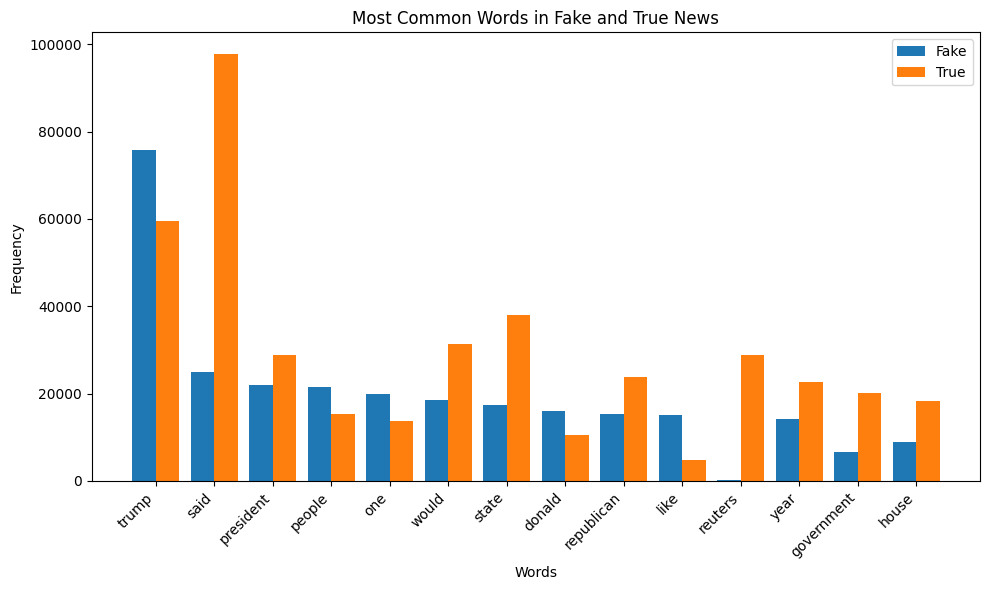

In [ ]:
# Combine text from both datasets
fake_text = ' '.join(fake_news['combined'].astype(str))
true_text = ' '.join(true_news['combined'].astype(str))

# Tokenize the text
fake_words = word_tokenize(fake_text)
true_words = word_tokenize(true_text)

# Count word frequencies
fake_word_counts = Counter(fake_words)
true_word_counts = Counter(true_words)

# Get the 10 most common words from each dataset
top_fake_words = fake_word_counts.most_common(10)
top_true_words = true_word_counts.most_common(10)

# Combine the top words and counts into a dictionary for plotting
all_words = {}

for word, count in top_fake_words:
    all_words[word] = {'fake': count, 'true': true_word_counts.get(word, 0)}

for word, count in top_true_words:
  if word not in all_words:
    all_words[word] = {'fake': fake_word_counts.get(word,0), 'true': count}


# Create the plot
words = list(all_words.keys())
fake_counts = [all_words[word]['fake'] for word in words]
true_counts = [all_words[word]['true'] for word in words]

X_axis = np.arange(len(words))

plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, fake_counts, 0.4, label='Fake')
plt.bar(X_axis + 0.2, true_counts, 0.4, label='True')

plt.xticks(X_axis, words, rotation=45, ha='right')  # Rotate x-axis labels
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Fake and True News")
plt.legend()
plt.tight_layout()
pathname = '/content/drive/My Drive/Data Mining Project/Plots/'
plt.savefig(pathname + 'Most_common_words.png')
plt.show()

In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(words, open(pathname + 'words.pkl', 'wb'))
pickle.dump(fake_counts, open(pathname + 'fake_counts.pkl', 'wb'))
pickle.dump(true_counts, open(pathname + 'true_counts.pkl', 'wb'))

#### Count Of News Subject In Fake/True News.

In [ ]:
fake_news['subject'].value_counts()


,count
subject,
politicsNews,11214
worldnews,9978


In [ ]:
true_news['subject'].value_counts()


,count
subject,
News,9050
politics,6425
US_News,783
left-news,683
Government News,514


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Data Mining Project/df.csv')

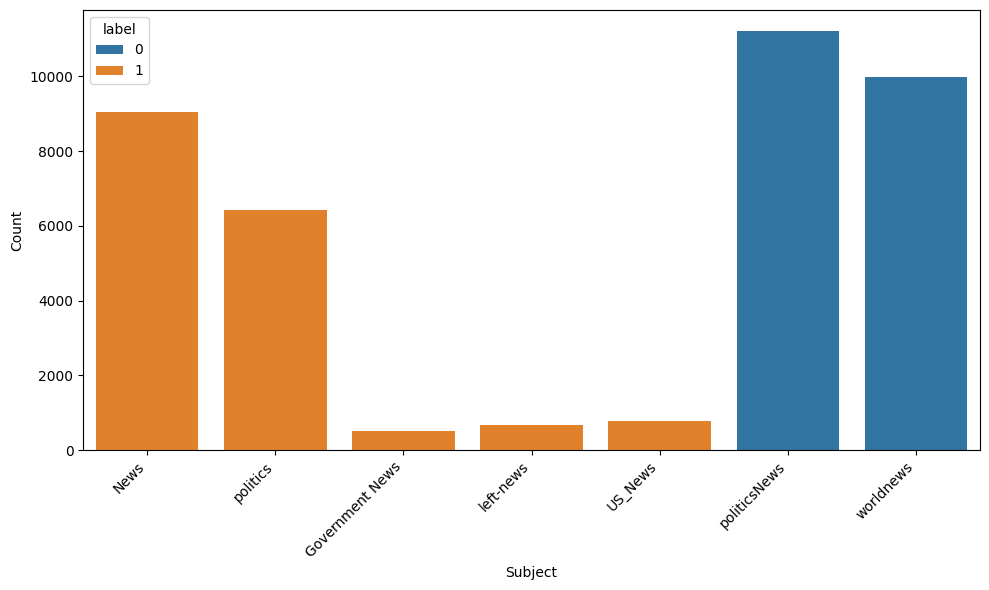

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='subject', hue='label')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Data Mining Project/Plots/count_of_news_subject.png')
plt.show()

## 3. Feature Engineering: TF-IDF
The idea of doing TD-IDF is to convert text into numberical values so that the model ca be trained y fitting those value in.
* First, we need to merged title and article context together.
* Classfify X as the merged text, and y as the label. (fake = 1, true = 0).
* Feed X into TF-IDF. Output will be (number of articles, number of unique words). The value of the output matrix will be the TF-IDF values.

In [ ]:
# First combined text
df['combined'][0]

'donald trump sends embarrassing new year eve message disturbing donald trump wish american happy new year leave instead give shout enemy hater dishonest fake news medium former reality show star one job country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year president angry pant tweeted 2018 great year america country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year 2018 great year america donald trump december 31 2017trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan december 31 2017no one like calvin december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yaver december 31 2017do hear talk include many peop

In [ ]:
# Setting predictor variables
X = df['combined'].values
y = df['label'].values

In [ ]:
print(X.shape)
print(y.shape)

(38647,)
(38647,)


In [ ]:
# Converting data to str and handling missing values
X = df['combined'].astype(str).fillna("")

In [ ]:
# Initiate vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(vectorizer, open(pathname + 'tfidf_vectorizer.pkl', 'wb'))
pickle.dump(X, open(pathname + 'X.pkl', 'wb'))
pickle.dump(y, open(pathname + 'y.pkl', 'wb'))

In [ ]:
X[0].shape

(1, 100896)

In [ ]:
X

<38647x100896 sparse matrix of type '<class 'numpy.float64'>'
	with 6278505 stored elements in Compressed Sparse Row format>

### TSNE Plot

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="random")
X_tsne = tsne.fit_transform(X)  # Directly apply to sparse matrix

In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports'
pickle.dump(X_tsne,  open(pathname + 'X_tsne.pkl', 'wb'))

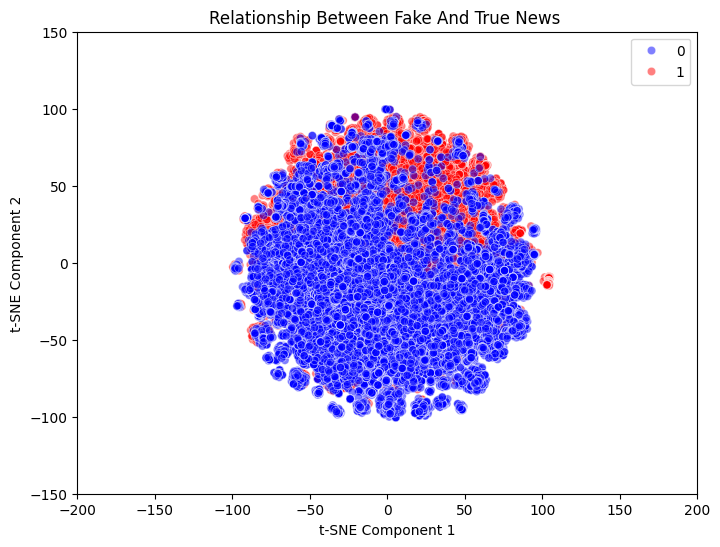

In [ ]:
# Scatter Plot for t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=['blue', 'red'], alpha=0.5)
plt.xlim([-200, 200]) # adjust the range in the x-axis
plt.ylim([-150, 150]) # adjust the range in the y-axis
plt.title("Relationship Between Fake And True News ")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

save_dir = "/content/drive/My Drive/Data Mining Project/Plots"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, 'tsne_plot.png'))

plt.show()

## 4. Train / Test Splitting
Splitting by using ratio of 70/30 (70% of the data will be trained, 30% of the data will be used to test).

In [ ]:
# The split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# Saving train-test set
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(X_train, open(pathname + 'X_train.pkl', 'wb'))
pickle.dump(X_test, open(pathname + 'X_test.pkl', 'wb'))
pickle.dump(y_train, open(pathname + 'y_train.pkl', 'wb'))
pickle.dump(y_test, open(pathname + 'y_test.pkl', 'wb'))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27052, 100896)
(11595, 100896)
(27052,)
(11595,)


## 5. Create Models To Train
There are the models we will use in this project:
* SVM
* Neural Network
* Ensemble (Adaboost)
* Ensemble (Bagging)
* Decision Tree



### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(penalty='l2', C=0.1)  # Example: L2 regularization with C=0.1
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
print(f'Accuracy: {lr_accuracy:.4f}')

Accuracy: 0.9682


In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(lr_model, open(pathname + 'lr_model.sav', 'wb'))

### SVM

In [ ]:
svm_model = SVC(
    probability = True,
    kernel = 'rbf',
    C = 1.0,
    gamma = 'scale',
    class_weight = 'balanced',
    random_state=42
) # creates the model
svm_model.fit(X_train, y_train) # trains the model
svm_pred = svm_model.predict(X_test) # makes predictions on test set

svm_accuracy = accuracy_score(y_test, svm_pred) # evaluates model
print(f'Accuracy: {svm_accuracy:.4f}')

Accuracy: 0.9909


In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(svm_model, open(pathname + 'svm_model.sav', 'wb'))

### Neural Network

In [ ]:
input_dim = X_train.shape[1]

nn_model = Sequential()
nn_model.add(Input(shape=(input_dim,)))
nn_model.add(Dense(units=64, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=32, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the NN
nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Train the NN Model
nn_model.fit(X_train, y_train, batch_size = 32, epochs = 10)

Epoch 1/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.9441 - loss: 0.2255
Epoch 2/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 123s 90ms/step - accuracy: 0.9989 - loss: 0.0058
Epoch 3/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 73s 87ms/step - accuracy: 0.9998 - loss: 0.0016
Epoch 4/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 1.0000 - loss: 2.7798e-04
Epoch 5/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - accuracy: 0.9999 - loss: 8.8887e-04
Epoch 6/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 1.0000 - loss: 8.4365e-05
Epoch 7/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.9999 - loss: 9.1239e-04
Epoch 8/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 1.0000 - loss: 7.4790e-05
Epoch 9/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 73s 86ms/step - accuracy: 0.9999 - loss: 4.1412e-04
Epoch 10/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 1.0000 - loss: 1.2593e-04


In [ ]:
nn_pred = nn_model.predict(X_test).round() # makes prediction
nn_accuracy = accuracy_score(y_test, nn_pred) # evaluates model
print(f'Accuracy: {nn_accuracy:.4f}')

363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Accuracy: 0.9906


In [ ]:
pickle.dump(nn_model, open(pathname + 'nn_model.sav', 'wb'))

### Ensemble (Bagging)

In [ ]:
bag_model = BaggingClassifier(
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8
) # creates the model with parameters to avoid overfitting
bag_model.fit(X_train, y_train) # trains the model
bag_pred = bag_model.predict(X_test) # makes prediction on test set

bag_accuracy = accuracy_score(y_test, bag_pred) # evaluates model
print(f"Accuracy: {bag_accuracy:.4f}")

Accuracy: 0.9967


In [ ]:
pickle.dump(bag_model, open(pathname + 'bag_model.sav', 'wb'))

### Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
) # creates the model with parameters to avoid overfitting
dt_model.fit(X_train, y_train) # trains the model
dt_pred = dt_model.predict(X_test) # makes prediction on test set

dt_accuracy = accuracy_score(y_test, dt_pred) # evaluates model
print(f"Accuracy: {dt_accuracy:.4f}")

Accuracy: 0.9952


In [ ]:
pickle.dump(dt_model, open(pathname + 'dt_model.sav', 'wb'))

## 6. Metrics Evaluation

In [ ]:
# Our set of models
models = {
    "Logistic Regression": lr_model,
    "SVM": svm_model,
    "Neural Network": nn_model,
    "Ensemble (Bagging)": bag_model,
    "Decision Tree": dt_model
}

### Sample ROC-AUC score code for one of the models (SVM)

In [ ]:
# Predict probabilities on test data (svm)
model = svm_model
predict_proba = model.predict_proba(X_test)
predict_proba

In [ ]:
# Extract probabilities of fake news
predict_proba_positive = predict_proba[:, 1]
predict_proba_positive

In [ ]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, predict_proba_positive)
print(f"ROC AUC Score: {roc_auc:.4f}")

### Running through all the models

In [ ]:
auc_scores = {}
predict_proba_dict = {}

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Neural Network: Get probabilities from the output layer
        predict_proba = model.predict(X_test)
        predict_proba = predict_proba.ravel()
    else:
        # For other models, use predict_proba to get probabilities for the positive class
        predict_proba = model.predict_proba(X_test)[:, 1]  # This gets the probability for the positive class (index 1)

    predict_proba_dict[model_name] = predict_proba

    # Calculate ROC AUC score and store it in auc_scores
    try:
        roc_auc = roc_auc_score(y_test, predict_proba)
        auc_scores[model_name] = roc_auc
        print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    except Exception as e:
        print(f"Error calculating ROC AUC for {model_name}: {e}")

Logistic Regression ROC AUC Score: 0.9944
SVM ROC AUC Score: 0.9988
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Neural Network ROC AUC Score: 0.9987
Ensemble (Bagging) ROC AUC Score: 0.9997
Decision Tree ROC AUC Score: 0.9943


In [ ]:
pathname = '/content/drive/My Drive/Data Mining Project/Imports/'
pickle.dump(auc_scores, open(pathname + 'auc_scores.pkl', "wb"))

In [ ]:
predict_proba_dict

{'SVM': array([5.15974129e-04, 1.29947092e-01, 1.92487841e-05, ...,
        9.99999991e-01, 9.99994338e-01, 1.00000000e+00]),
 'Neural Network': array([1.8046136e-09, 4.8240454e-06, 1.8235061e-08, ..., 9.9999988e-01,
        9.9999768e-01, 9.9999982e-01], dtype=float32),
 'Ensemble (AdaBoost)': array([0.4254089 , 0.33089215, 0.36820427, ..., 0.6678166 , 0.61786959,
        0.67560367]),
 'Ensemble (Bagging)': array([0.08, 0.  , 0.  , ..., 0.94, 0.98, 0.98]),
 'Decision Tree': array([0., 0., 0., ..., 1., 1., 1.])}

### Producing a plot for ROC curves

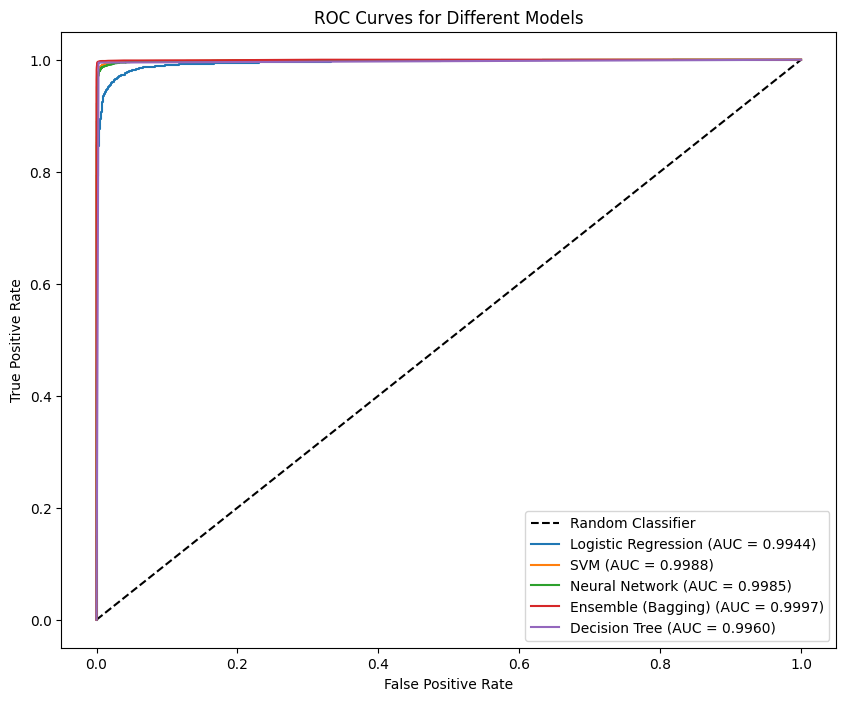

In [ ]:
save_dir = "/content/drive/My Drive/Data Mining Project/Plots/"
os.makedirs(save_dir, exist_ok=True)

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Plot ROC curve for each model
for model_name, predict_proba in predict_proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Labels and Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')

# Display legend
plt.legend(loc = "lower right")

# Show the plot
save_path = os.path.join(save_dir, 'roc_curves.png')
plt.savefig(save_path)
plt.show()

* Closer to the Top-Left Corner: Indicates a better performance. This means a higher TPR and a lower FPR.
* Area Under the Curve (AUC): A single scalar value summarizing the performance of the classifier. The closer the AUC is to 1, the better the model.

### Code to generate individual plots for each model

In [ ]:
save_dir = "/content/drive/My Drive/Data Mining Project/Plots/"
os.makedirs(save_dir, exist_ok=True)

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Neural Network: Get probabilities from the output layer
        predict_proba = model.predict(X_test)
        predict_proba = predict_proba.ravel()
    else:
        # For other models, use predict_proba to get probabilities for the positive class
        predict_proba = model.predict_proba(X_test)[:, 1]  # This gets the probability for the positive class (index 1)

    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # Save the plot to Google Drive
    save_path = os.path.join(save_dir, f'{model_name}_ROC_Curve.png')
    plt.savefig(save_path)
    plt.close()  # Close the plot to avoid overlapping

363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


### Code to generate individual confusion matrices for each model

In [ ]:
for model_name, model in models.items():
    # Predict on the test set
    if model_name == "Neural Network":
        y_pred = model.predict(X_test).round()
    else:
        y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))  # Customize figure size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake']) # Customize colormap and labels
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Save the plot
    save_path = os.path.join(save_dir, f'{model_name}_Confusion_Matrix.png')
    plt.savefig(save_path)
    plt.close() # Close the plot

363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


### Code to generate accuracy, precision, recall, and F1-score for each model

In [ ]:
for model_name, model in models.items():
    # Predict on the test set
    if model_name == "Neural Network":
        y_pred = model.predict(X_test).round()
    else:
        y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("-" * 20)  # Separator for better readability

Model: Logistic Regression
  Accuracy: 0.9682
  Precision: 0.9804
  Recall: 0.9489
  F1-score: 0.9644
--------------------
Model: SVM
  Accuracy: 0.9909
  Precision: 0.9926
  Recall: 0.9875
  F1-score: 0.9900
--------------------
363/363 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Model: Neural Network
  Accuracy: 0.9906
  Precision: 0.9907
  Recall: 0.9886
  F1-score: 0.9896
--------------------
Model: Ensemble (Bagging)
  Accuracy: 0.9966
  Precision: 0.9990
  Recall: 0.9935
  F1-score: 0.9963
--------------------
Model: Decision Tree
  Accuracy: 0.9952
  Precision: 0.9968
  Recall: 0.9926
  F1-score: 0.9947
--------------------


# Loading

In [ ]:
# I saved some things in the drive so that we don't have to
# fit the models again everytime
# We only need to run this cell

filename = '/content/drive/My Drive/Data Mining Project/Imports'
lr_model = pickle.load(open(filename + '/lr_model.sav', 'rb'))
svm_model = pickle.load(open(filename + '/svm_model.sav', 'rb'))
nn_model = pickle.load(open(filename + '/nn_model.sav', 'rb'))
bag_model = pickle.load(open(filename + '/bag_model.sav', 'rb'))
dt_model = pickle.load(open(filename + '/dt_model.sav', 'rb'))
vectorizer = pickle.load(open(filename + "/tfidf_vectorizer.pkl", "rb"))
X_test = pickle.load(open(filename + "/X_test.pkl", "rb"))
y_test = pickle.load(open(filename + "/y_test.pkl", "rb"))
X_train = pickle.load(open(filename + "/X_train.pkl", "rb"))
y_train = pickle.load(open(filename + "/y_train.pkl", "rb"))
auc_scores = pickle.load(open(filename + "/auc_scores.pkl", "rb"))


In [ ]:
models = {
    "Logistic Regression": lr_model,
    "SVM": svm_model,
    "Neural Network": nn_model,
    "Ensemble (Bagging)": bag_model,
    "Decision Tree": dt_model
}

## Final Task: Pass A Random Text Here to Predict If It's A Fake News Or Not.
Here is the workflow of the fucntion of detecting fake news:
1.  Check the user's input. If they don't put any --> skip.
2.  If there is input, then continue feed those texts into TF-IDF to create a numerical vector.
3. Since we already saved the models, we loop through each model, then:
* If the model is not a Neural Network, it directly takes the prediction ([0] to get the first prediction)
* For Neural Networks, the prediction is rounded (.round()) to get a binary output (0 or 1).
* Print and store predictions from those models.
* Print the probability prediction for Fake news (percentage of being a fake news) --> if the model doesn't have this prediction , prints out N/A.
4. Print out AUC score for each models to test their performances.
5. After have all the prediction, if the majority of predictions are Fake, then it's a fake article. Otherwise, it's a real article.


In [ ]:
# Method to predict fake news
def predict_fake_news(user_text):
    # Check if the text is empty before prediction
    if not user_text:  # If user_text is empty, it will skip this article
        print("Empty text received, skipping prediction.")
        return

    text_vectorized = vectorizer.transform([user_text])

    predictions = [] # Initialize an empty list to store predictions

    print("\nPrediction Results:")
    for name, model in models.items():
        prediction = model.predict(text_vectorized)[0] if name != "Neural Network" else model.predict(text_vectorized).round()[0]
        predictions.append(prediction) # Append the prediction to the list
        prob = model.predict_proba(text_vectorized)[:, 1] if hasattr(model, "predict_proba") else "N/A"
        print(f"{name}: {'Fake' if prediction == 1 else 'Real'}, Probability: {prob}")

    # Majority vote using the list of predictions
    majority_vote = sum(predictions) > len(predictions) / 2

    print("\nThis article is more likely: " + ("Fake" if majority_vote else "Real"))

In [ ]:
# Method to extract needed text from URLS
def extract_website_text(url):
    try:
        article = Article(url) # creates an article project with url as input
        article.download() # downloads content at given url
        article.parse() # parses content to extract necessary data

        # Get the headline and article text
        headline = article.title
        content = article.text

        # Combine headline and content
        extracted_text = f"{headline} {content}"
        return extracted_text

    except Exception as e:
        print(f"Error extracting text from URL: {e}")
        return ""

# User Input

In [ ]:
user_input = input("Enter 1 for text, Enter 2 for URLs: ")
if user_input == "1":
    user_input = input("Enter your text: ")
    predict_fake_news(user_input)
elif user_input == "2":
    user_input = input("Enter the URL: ")
    website_text = extract_website_text(user_input)
    predict_fake_news(website_text)
else:
    print("Invalid input. Please enter 1 or 2.")

Enter 1 for text, Enter 2 for URLs: 2
Enter the URL: https://www.whitehouse.gov/articles/2025/03/president-trump-is-remaking-america-into-a-manufacturing-superpower/

Prediction Results:
Logistic Regression: Real, Probability: [0.42283734]
SVM: Fake, Probability: [0.80144428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Neural Network: Fake, Probability: N/A
Ensemble (Bagging): Fake, Probability: [0.9]
Decision Tree: Fake, Probability: [0.99941798]

This article is more likely: Fake
